In [1]:
# https://data.mendeley.com/datasets/wmy84gzngw/1
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/wmy84gzngw-1.zip

--2022-11-06 03:54:03--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/wmy84gzngw-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.44.162, 52.92.2.82, 52.218.100.96, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.44.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3194531 (3.0M) [application/octet-stream]
Saving to: ‘wmy84gzngw-1.zip’

wmy84gzngw-1.zip    100%[===================>]   3.05M  4.44MB/s    in 0.7s    

2022-11-06 03:54:05 (4.44 MB/s) - ‘wmy84gzngw-1.zip’ saved [3194531/3194531]



## Loading libraries and modules

In [2]:
import os
import random
import shutil

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

from torchvision import transforms as T, datasets, models
from torchvision.utils import make_grid
from torchvision.io import read_image

from zipfile import ZipFile

from PIL import Image

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from tqdm.auto import tqdm, trange

from pprint import pprint

# Set global config
pd.set_option('display.max_colwidth', None)
SEED = 2022

%config InlineBackend.figure_format = 'retina'

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## Preparing data

In [4]:
data_dict = {
    'image_path': [],
    'label': [],
}

for dirpath, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        
        if not ('mask' in filename):
            
            image_path = os.path.join(dirpath, filename)
            image_label = dirpath.split('/')[-1]
        
            data_dict['image_path'].append(image_path)
            data_dict['label'].append(image_label)

In [5]:
label_encoder = {
    'normal': 0,
    'benign': 1,
    'malignant': 2,
}

df_busi = pd.DataFrame(data_dict)

# Encode labels
df_busi['label'] = df_busi['label'].map(label_encoder)

print(f'BUSI dataset contains {df_busi.shape[0]:_d} rows and {df_busi.shape[1]:_d} columns', '\n')
df_busi

BUSI dataset contains 780 rows and 2 columns 



,image_path,label
0,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (2).png,1
1,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (285).png,1
2,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (300).png,1
3,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (390).png,1
4,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (357).png,1
...,...,...
775,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (124).png,2
776,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (133).png,2
777,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (6).png,2
778,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (193).png,2


In [6]:
df_busi['label'].value_counts(dropna=False).sort_index()

0    133
1    437
2    210
Name: label, dtype: int64

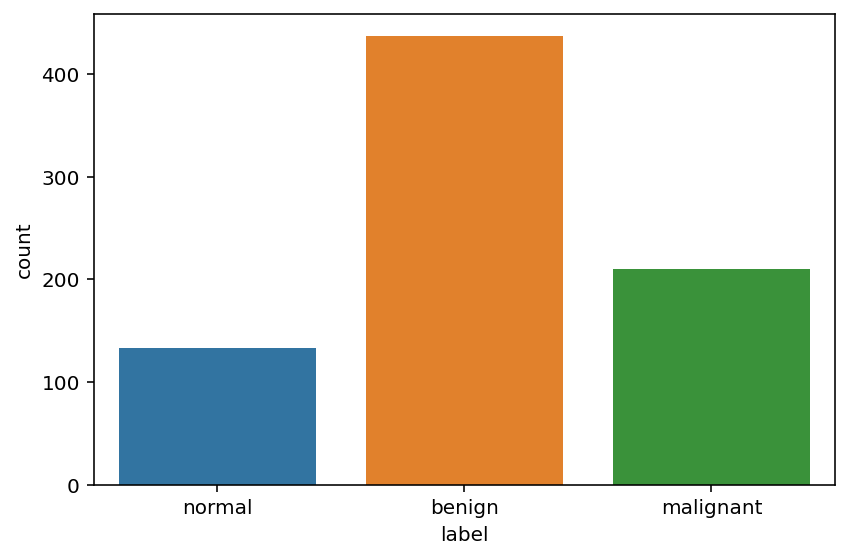

In [7]:
_ = sns.countplot(data=df_busi, x='label')
plt.xticks(ticks=[0, 1, 2], labels=['normal', 'benign', 'malignant'])
plt.tight_layout()

## Adding more data
__Breast Ultrasound Image__

---
Published: 31 December 2017 | Version 1 | DOI: 10.17632/wmy84gzngw.1
Contributor: Paulo Sergio Rodrigues

---
__Description__    
This database contains 250 breast cancer images, 100 benign and 150 malignant. It is a database already widely used in the literature.

In [8]:
zip_file = './wmy84gzngw-1.zip'

with ZipFile(zip_file) as zip_file:
    zip_file.extractall()
    
with ZipFile('./us-dataset.zip') as zip_file:
    zip_file.extractall()

In [9]:
bui_data_dict = {
    'image_path': [],
    'label': [],
}

for dirpath, _, filenames in os.walk('./'):
    
    for filename in filenames:      
        if filename.endswith('.bmp'):
            
            bui_img_path  = os.path.join(dirpath, filename)
            bui_img_label = dirpath.split('/')[-1]
        
            bui_data_dict['image_path'].append(bui_img_path)
            bui_data_dict['label'].append(bui_img_label)

In [10]:
bui_label_encoder = {
    'benign': 1,
    'malignant': 2,
}

df_bui = pd.DataFrame(bui_data_dict)

# Encode labels
df_bui['label'] = df_bui['label'].map(bui_label_encoder)

print(f'BUI dataset contains {df_bui.shape[0]:_d} rows and {df_bui.shape[1]:_d} columns', '\n')
df_bui

BUI dataset contains 250 rows and 2 columns 



,image_path,label
0,./originals/malignant/us245.bmp,2
1,./originals/malignant/us136.bmp,2
2,./originals/malignant/us193.bmp,2
3,./originals/malignant/us248.bmp,2
4,./originals/malignant/us157.bmp,2
...,...,...
245,./originals/benign/us64.bmp,1
246,./originals/benign/us89.bmp,1
247,./originals/benign/us12.bmp,1
248,./originals/benign/us74.bmp,1


In [11]:
df_bui['label'].value_counts(dropna=False).sort_index()

1    100
2    150
Name: label, dtype: int64

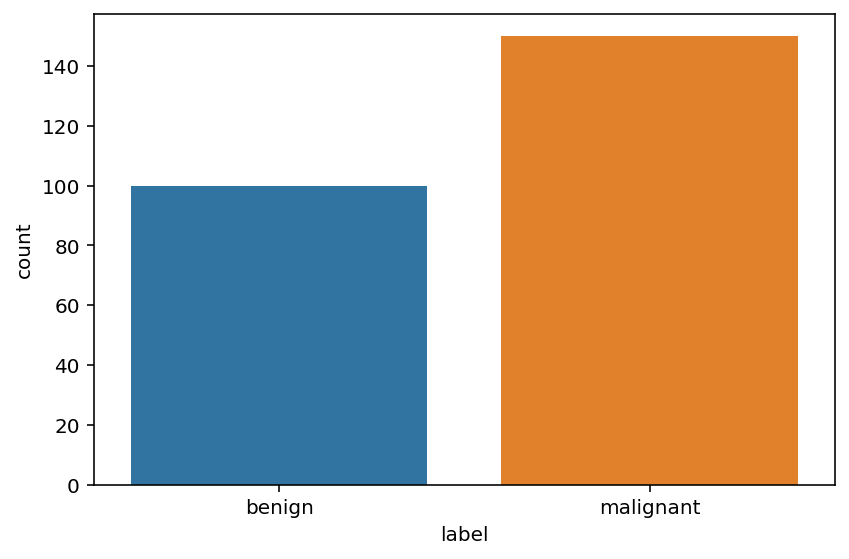

In [12]:
_ = sns.countplot(data=df_bui, x='label')
plt.xticks(ticks=[0, 1], labels=['benign', 'malignant'])
plt.tight_layout()

### Concatenating data

In [13]:
df = pd.concat([df_busi, df_bui])
df

,image_path,label
0,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (2).png,1
1,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (285).png,1
2,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (300).png,1
3,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (390).png,1
4,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (357).png,1
...,...,...
245,./originals/benign/us64.bmp,1
246,./originals/benign/us89.bmp,1
247,./originals/benign/us12.bmp,1
248,./originals/benign/us74.bmp,1


In [14]:
df['label'].value_counts(dropna=False).sort_index()

0    133
1    537
2    360
Name: label, dtype: int64

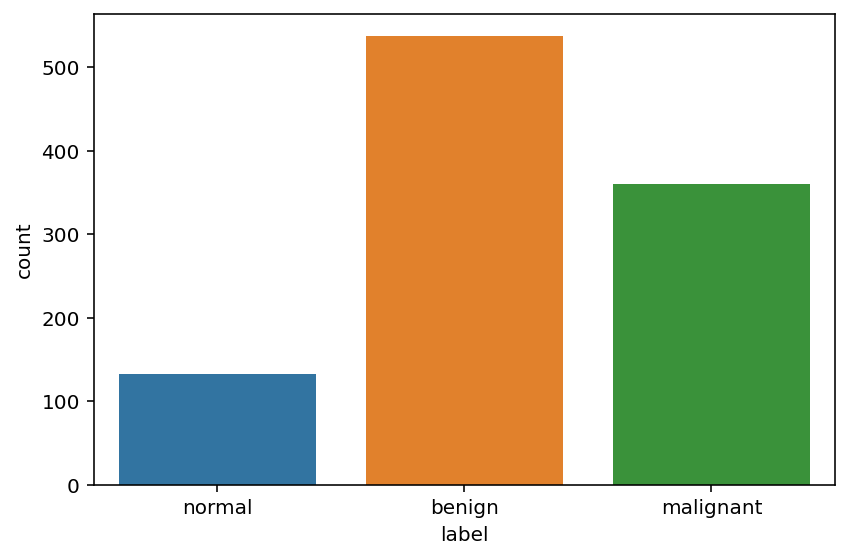

In [15]:
_ = sns.countplot(data=df, x='label')
plt.xticks(ticks=[0, 1, 2], labels=['normal', 'benign', 'malignant'])
plt.tight_layout()

In [16]:
# Sanity check
df['image_path'].nunique(), df['label'].unique()

(1030, array([1, 0, 2]))

## Prepraring data to feed the model

In [17]:
class BUSIDataset(Dataset):
    def __init__(self, annotations, transform=None):
        self.annotations = annotations
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.annotations.iloc[index, 0])
        image = Image.open(image_path).convert('RGB')
        label = self.annotations.iloc[index, 1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [18]:
# Split data into 80% for training and 20% for testing: 
df_train, df_test = train_test_split(df, test_size=0.20, random_state=SEED, stratify=df['label'])

# Sanity check
df_train.shape, df_test.shape

((824, 2), (206, 2))

In [19]:
transforms_dict = {
    'train': T.Compose([T.Resize((224, 224)),
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])]),
    
    'valid': T.Compose([T.Resize((224, 224)),
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])])
}

train_data = BUSIDataset(df_train, transform=transforms_dict['train'])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, 
                          num_workers=2, pin_memory=True)

test_data = BUSIDataset(df_test, transform=transforms_dict['valid'])
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, 
                         num_workers=0, pin_memory=True)

## Plotting some images

In [20]:
def show_images(images, labels, preds):
    
    img_label_decoder = {
        0: 'normal',
        1: 'benign',
        2: 'malignant',
    }

    plt.figure(figsize=(12, 5))

    for ii, image in enumerate(images[:8]):

        plt.subplot(2, 4, ii + 1, xticks=[], yticks=[])

        image = image.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])    
        std  = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, a_min=0, a_max=1)
        plt.imshow(image, cmap='bone')

        color = 'green'
        if preds[ii] != labels[ii]:
            color = 'red'

        plt.xlabel(f'{img_label_decoder[int(labels[ii].numpy())]}')
        plt.ylabel(f'{img_label_decoder[int(preds[ii].numpy())]}', color=color)
        
    plt.tight_layout()
    plt.show()

In [21]:
images, labels = next(iter(train_loader))

images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

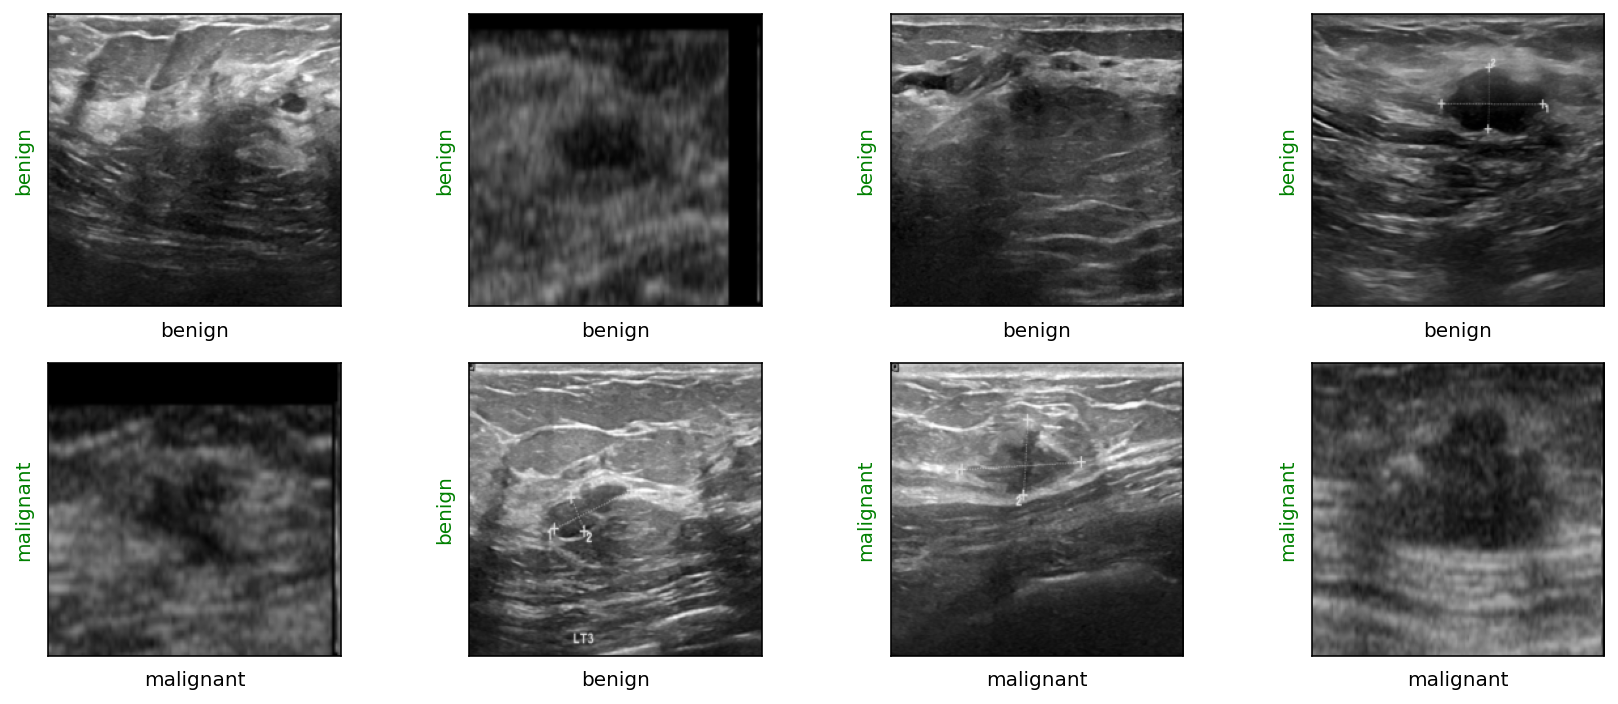

In [22]:
show_images(images, labels, labels)

In [23]:
class BUSIClassifier(nn.Module):
    def __init__(self, pretrained=True, requires_grad=False):
        super().__init__()
        
        self.model = models.resnet50(pretrained=pretrained)
        
        print(f'[INFO] pretrained is {True if pretrained else False}')
        
        # Freeze features parameters
        if not requires_grad:
            
            print('[INFO] requires_grad is False')
            for params in self.model.parameters():
                params.requires_grad = False
                
        else:
            print('[INFO] requires_grad is True')
            
        self.model.fc = nn.Linear(in_features=2048, out_features=3, bias=True)
        
    def forward(self, x):
        
        logits = self.model(x)
        
        return logits

In [24]:
def model_train(loader, model, criterion, optimizer):

    running_loss, accuracy = 0, 0
    y_true, y_pred = [], []

    # Set training mode
    model.train()
    for images, labels in loader:

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = model(images)
        loss = criterion(logits, labels)

        # Backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Store training loss
        running_loss += loss.item()

        # Calculate and store accuracy
        _, preds = torch.max(logits, dim=1)
        
        y_true.extend(labels.detach().cpu().numpy())
        y_pred.extend(preds.detach().cpu().numpy())
        
    return (
        (running_loss / len(loader)),                 # loss
        (accuracy_score(y_true, y_pred)),             # accuracy 
        (f1_score(y_true, y_pred, average='macro')),  # macro f1-score  
    )

In [25]:
@torch.no_grad() # turn off gradients
def model_eval(loader, model, criterion):
    
    valid_loss, accuracy = 0, 0
    y_true, y_pred = [], []
    
    # Set evaluation mode
    model.eval()
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        # Store validation loss
        valid_loss += loss.item()

        # Calculate and store accuracy
        _, preds = torch.max(logits, dim=1)
        
        y_true.extend(labels.detach().cpu().numpy())
        y_pred.extend(preds.detach().cpu().numpy())
        

    scheduler.step(valid_loss / len(valid_loader))
    
    return (
        (valid_loss / len(loader)),                  # loss
        (accuracy_score(y_true, y_pred)),            # accuracy 
        (f1_score(y_true, y_pred, average='macro'))  # f1-score
    )

## Training and validating model

### Training from scratch

In [26]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for ii, (train_indices, valid_indices) in enumerate(skfold.split(df_train, df_train['label']), start=1):

    train = df_train.iloc[train_indices]
    valid = df_train.iloc[valid_indices]

    # Split data into traininig and validation sets
    train_data = BUSIDataset(train, transform=transforms_dict['train'])
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

    valid_data = BUSIDataset(valid, transform=transforms_dict['valid'])
    valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    print('\n-------')
    print(f'FOLD {ii}')
    print('-------\n')

    # Select avaiable device: GPU or CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Instantiate the model
    model = BUSIClassifier(pretrained=False, requires_grad=True)
    model.to(device)

    # Define the loss, optimizar and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, verbose=True)

    epochs = 50

    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [], 
        'valid_loss': [], 'valid_acc': [], 'valid_f1': [],
    }

    valid_loss_min = np.Inf

    for epoch in trange(epochs):

        train_loss, train_acc, train_f1 = model_train(train_loader, model, criterion, optimizer)
        valid_loss, valid_acc, valid_f1 = model_eval(valid_loader, model, criterion)

        print(f'Epoch: {epoch + 1:02d}/{epochs:02d} ',
              f'Training loss: {train_loss:10.5f} | ',
              f'Training Accuracy: {train_acc:5.2%} | ',
              f'Training f1 score: {train_f1:.5f} | '
              f'Validation loss: {valid_loss:10.5f} | ',
              f'Validation Accuracy: {valid_acc:5.2%} | ',
              f'Validation f1 score: {valid_f1:5.5f}')

        if valid_loss <= valid_loss_min:
            print(f'Validation loss decresead: {valid_loss_min:.5f} --> {valid_loss:.5f}. Saving model...')            
            valid_loss_min = valid_loss
            best_model  = torch.save(model.state_dict(), f'model_{ii:02d}.pt')
            best_model_train_loss = train_loss
            best_model_train_acc = train_acc
            best_model_train_f1 = train_f1
            best_model_valid_loss = valid_loss
            best_model_valid_acc = valid_acc
            best_model_valid_f1 = valid_f1

        history['train_loss'].append(best_model_train_loss)
        history['train_acc'].append(best_model_train_acc)
        history['train_f1'].append(best_model_train_f1)
        history['valid_loss'].append(best_model_valid_loss)
        history['valid_acc'].append(best_model_valid_acc)
        history['valid_f1'].append(best_model_valid_f1)

print('\n--------------')            
print(f"Training loss: {np.mean(history['train_loss']):.5f} +/- {np.std(history['train_loss']):.5f} | "
      f"Validation loss: {np.mean(history['valid_loss']):.5f} +/- {np.std(history['valid_loss']):.5f} | "
      f"Training accuracy: {np.mean(history['train_acc']):.2%} +/- {np.std(history['train_acc']):.2%} | "
      f"Validation accuracy: {np.mean(history['valid_acc']):.2%} +/- {np.std(history['valid_acc']):.2%} | "
      f"Training f1 score: {np.mean(history['train_f1']):.5f} +/- {np.std(history['train_f1']):.5f} | "
      f"Validation f1 score: {np.mean(history['valid_f1']):.5f} +/- {np.std(history['valid_f1']):.5f}")
print('--------------')


-------
FOLD 1
-------

[INFO] pretrained is False
[INFO] requires_grad is True


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    1.26651 |  Training Accuracy: 52.03% |  Training f1 score: 0.43389 | Validation loss:    2.72998 |  Validation Accuracy: 39.39% |  Validation f1 score: 0.28063
Validation loss decresead: inf --> 2.72998. Saving model...
Epoch: 02/50  Training loss:    0.81334 |  Training Accuracy: 62.34% |  Training f1 score: 0.53433 | Validation loss:    0.70170 |  Validation Accuracy: 62.42% |  Validation f1 score: 0.50230
Validation loss decresead: 2.72998 --> 0.70170. Saving model...
Epoch: 03/50  Training loss:    0.73354 |  Training Accuracy: 65.78% |  Training f1 score: 0.58864 | Validation loss:    0.92723 |  Validation Accuracy: 63.03% |  Validation f1 score: 0.45438
Epoch: 04/50  Training loss:    0.64823 |  Training Accuracy: 73.44% |  Training f1 score: 0.66652 | Validation loss:    0.95607 |  Validation Accuracy: 59.39% |  Validation f1 score: 0.53695
Epoch: 05/50  Training loss:    0.57779 |  Training Accuracy: 74.84% |  Training f1 score: 0.70343 | Validat

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    1.13128 |  Training Accuracy: 55.16% |  Training f1 score: 0.39232 | Validation loss:    1.36937 |  Validation Accuracy: 37.58% |  Validation f1 score: 0.20619
Validation loss decresead: inf --> 1.36937. Saving model...
Epoch: 02/50  Training loss:    0.83661 |  Training Accuracy: 62.97% |  Training f1 score: 0.47766 | Validation loss:    0.82695 |  Validation Accuracy: 55.76% |  Validation f1 score: 0.53369
Validation loss decresead: 1.36937 --> 0.82695. Saving model...
Epoch: 03/50  Training loss:    0.74891 |  Training Accuracy: 65.47% |  Training f1 score: 0.55467 | Validation loss:    0.83803 |  Validation Accuracy: 55.76% |  Validation f1 score: 0.36571
Epoch: 04/50  Training loss:    0.71038 |  Training Accuracy: 69.38% |  Training f1 score: 0.64682 | Validation loss:    0.86790 |  Validation Accuracy: 61.82% |  Validation f1 score: 0.56304
Epoch: 05/50  Training loss:    0.66798 |  Training Accuracy: 71.09% |  Training f1 score: 0.67785 | Validat

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    1.23599 |  Training Accuracy: 51.41% |  Training f1 score: 0.37891 | Validation loss:    1.32182 |  Validation Accuracy: 41.82% |  Validation f1 score: 0.27455
Validation loss decresead: inf --> 1.32182. Saving model...
Epoch: 02/50  Training loss:    0.87237 |  Training Accuracy: 60.47% |  Training f1 score: 0.42921 | Validation loss:    0.80612 |  Validation Accuracy: 56.36% |  Validation f1 score: 0.40224
Validation loss decresead: 1.32182 --> 0.80612. Saving model...
Epoch: 03/50  Training loss:    0.75921 |  Training Accuracy: 66.88% |  Training f1 score: 0.56021 | Validation loss:    0.75040 |  Validation Accuracy: 68.48% |  Validation f1 score: 0.65882
Validation loss decresead: 0.80612 --> 0.75040. Saving model...
Epoch: 04/50  Training loss:    0.65945 |  Training Accuracy: 70.16% |  Training f1 score: 0.63974 | Validation loss:    0.93617 |  Validation Accuracy: 67.88% |  Validation f1 score: 0.61998
Epoch: 05/50  Training loss:    0.67803 |  T

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    1.16844 |  Training Accuracy: 53.75% |  Training f1 score: 0.41199 | Validation loss:    2.00989 |  Validation Accuracy: 34.55% |  Validation f1 score: 0.17117
Validation loss decresead: inf --> 2.00989. Saving model...
Epoch: 02/50  Training loss:    0.80347 |  Training Accuracy: 61.09% |  Training f1 score: 0.44612 | Validation loss:    0.93343 |  Validation Accuracy: 60.61% |  Validation f1 score: 0.45968
Validation loss decresead: 2.00989 --> 0.93343. Saving model...
Epoch: 03/50  Training loss:    0.70663 |  Training Accuracy: 67.66% |  Training f1 score: 0.57596 | Validation loss:    0.72315 |  Validation Accuracy: 72.12% |  Validation f1 score: 0.59390
Validation loss decresead: 0.93343 --> 0.72315. Saving model...
Epoch: 04/50  Training loss:    0.61269 |  Training Accuracy: 73.75% |  Training f1 score: 0.65899 | Validation loss:   26.23926 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.22842
Epoch: 05/50  Training loss:    0.67151 |  T

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    1.34472 |  Training Accuracy: 53.12% |  Training f1 score: 0.39294 | Validation loss:    2.04438 |  Validation Accuracy: 34.76% |  Validation f1 score: 0.17195
Validation loss decresead: inf --> 2.04438. Saving model...
Epoch: 02/50  Training loss:    0.79233 |  Training Accuracy: 65.47% |  Training f1 score: 0.50789 | Validation loss:    0.75944 |  Validation Accuracy: 62.20% |  Validation f1 score: 0.51852
Validation loss decresead: 2.04438 --> 0.75944. Saving model...
Epoch: 03/50  Training loss:    0.68770 |  Training Accuracy: 69.84% |  Training f1 score: 0.55135 | Validation loss:    0.61616 |  Validation Accuracy: 71.95% |  Validation f1 score: 0.66622
Validation loss decresead: 0.75944 --> 0.61616. Saving model...
Epoch: 04/50  Training loss:    0.64527 |  Training Accuracy: 72.34% |  Training f1 score: 0.65135 | Validation loss:    0.73187 |  Validation Accuracy: 64.63% |  Validation f1 score: 0.46084
Epoch: 05/50  Training loss:    0.60765 |  T

## Evaluating model

In [27]:
y_pred_list = []

for jj in trange(1, 6):

    # Load saved model
    model.load_state_dict(torch.load(f'model_{jj:02d}.pt'))

    y_pred = []

    with torch.no_grad():
        
        model.eval()
        for images, _ in tqdm(test_loader):
            images = images.to(device)

            logits = model(images)

            _, preds = torch.max(logits, dim=1)
            y_pred.extend(preds.detach().cpu().numpy())
            
    y_pred_list.append(y_pred)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [28]:
df_test['pred'] = np.column_stack(y_pred_list).mean(axis=1).round()
df_test['pred'] = df_test['pred'].astype('int')  # cast predicted values
df_test

,image_path,label,pred
650,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (21).png,2,1
470,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (112).png,0,1
679,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (43).png,2,1
760,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (69).png,2,1
212,./originals/benign/us33.bmp,1,1
...,...,...,...
525,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (132).png,0,1
603,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (143).png,2,1
630,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (149).png,2,2
85,./originals/malignant/us211.bmp,2,2


In [29]:
target_names = ['normal', 'benign', 'malignant']
print(classification_report(y_true=df_test['label'], y_pred=df_test['pred'], target_names=target_names))

              precision    recall  f1-score   support

      normal       0.86      0.22      0.35        27
      benign       0.72      0.94      0.82       107
   malignant       0.90      0.74      0.81        72

    accuracy                           0.78       206
   macro avg       0.83      0.63      0.66       206
weighted avg       0.80      0.78      0.75       206



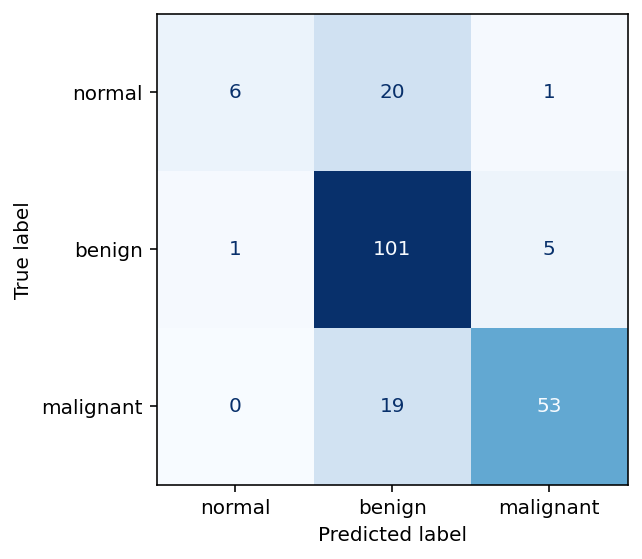

In [30]:
cm = confusion_matrix(y_true=df_test['label'], y_pred=df_test['pred'])
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot(cmap='Blues', colorbar=False)
plt.tight_layout()

## Fine Tuning

In [31]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for ii, (train_indices, valid_indices) in enumerate(skfold.split(df_train, df_train['label']), start=1):

    train = df_train.iloc[train_indices]
    valid = df_train.iloc[valid_indices]

    # Split data into traininig and validation sets
    train_data = BUSIDataset(train, transform=transforms_dict['train'])
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

    valid_data = BUSIDataset(valid, transform=transforms_dict['valid'])
    valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    print('\n-------')
    print(f'FOLD {ii}')
    print('-------\n')

    # Select avaiable device: GPU or CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Instantiate the model
    model = BUSIClassifier(pretrained=True, requires_grad=True)
    model.to(device)

    # Define the loss, optimizar and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, verbose=True)

    epochs = 50

    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [], 
        'valid_loss': [], 'valid_acc': [], 'valid_f1': [],
    }

    valid_loss_min = np.Inf

    for epoch in trange(epochs):

        train_loss, train_acc, train_f1 = model_train(train_loader, model, criterion, optimizer)
        valid_loss, valid_acc, valid_f1 = model_eval(valid_loader, model, criterion)

        print(f'Epoch: {epoch + 1:02d}/{epochs:02d} ',
              f'Training loss: {train_loss:10.5f} | ',
              f'Training Accuracy: {train_acc:5.2%} | ',
              f'Training f1 score: {train_f1:.5f} | '
              f'Validation loss: {valid_loss:10.5f} | ',
              f'Validation Accuracy: {valid_acc:5.2%} | ',
              f'Validation f1 score: {valid_f1:5.5f}')

        if valid_loss <= valid_loss_min:
            print(f'Validation loss decresead: {valid_loss_min:.5f} --> {valid_loss:.5f}. Saving model...')            
            valid_loss_min = valid_loss
            best_model  = torch.save(model.state_dict(), f'model_{ii:02d}.pt')
            best_model_train_loss = train_loss
            best_model_train_acc = train_acc
            best_model_train_f1 = train_f1
            best_model_valid_loss = valid_loss
            best_model_valid_acc = valid_acc
            best_model_valid_f1 = valid_f1

        history['train_loss'].append(best_model_train_loss)
        history['train_acc'].append(best_model_train_acc)
        history['train_f1'].append(best_model_train_f1)
        history['valid_loss'].append(best_model_valid_loss)
        history['valid_acc'].append(best_model_valid_acc)
        history['valid_f1'].append(best_model_valid_f1)

print('\n--------------')            
print(f"Training loss: {np.mean(history['train_loss']):.5f} +/- {np.std(history['train_loss']):.5f} | "
      f"Validation loss: {np.mean(history['valid_loss']):.5f} +/- {np.std(history['valid_loss']):.5f} | "
      f"Training accuracy: {np.mean(history['train_acc']):.2%} +/- {np.std(history['train_acc']):.2%} | "
      f"Validation accuracy: {np.mean(history['valid_acc']):.2%} +/- {np.std(history['valid_acc']):.2%} | "
      f"Training f1 score: {np.mean(history['train_f1']):.5f} +/- {np.std(history['train_f1']):.5f} | "
      f"Validation f1 score: {np.mean(history['valid_f1']):.5f} +/- {np.std(history['valid_f1']):.5f}")
print('--------------')


-------
FOLD 1
-------



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

[INFO] pretrained is True
[INFO] requires_grad is True


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    0.94605 |  Training Accuracy: 61.09% |  Training f1 score: 0.41604 | Validation loss:   73.02492 |  Validation Accuracy: 56.36% |  Validation f1 score: 0.30677
Validation loss decresead: inf --> 73.02492. Saving model...
Epoch: 02/50  Training loss:    0.74036 |  Training Accuracy: 65.78% |  Training f1 score: 0.58777 | Validation loss:    2.12273 |  Validation Accuracy: 58.79% |  Validation f1 score: 0.37316
Validation loss decresead: 73.02492 --> 2.12273. Saving model...
Epoch: 03/50  Training loss:    0.57899 |  Training Accuracy: 72.34% |  Training f1 score: 0.65317 | Validation loss:    1.69217 |  Validation Accuracy: 56.36% |  Validation f1 score: 0.39851
Validation loss decresead: 2.12273 --> 1.69217. Saving model...
Epoch: 04/50  Training loss:    0.52620 |  Training Accuracy: 77.81% |  Training f1 score: 0.76388 | Validation loss:    1.31958 |  Validation Accuracy: 58.18% |  Validation f1 score: 0.41630
Validation loss decresead: 1.69217 --> 1.3

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    0.78928 |  Training Accuracy: 64.69% |  Training f1 score: 0.53192 | Validation loss:   14.69119 |  Validation Accuracy: 46.67% |  Validation f1 score: 0.32988
Validation loss decresead: inf --> 14.69119. Saving model...
Epoch: 02/50  Training loss:    0.48656 |  Training Accuracy: 82.03% |  Training f1 score: 0.79769 | Validation loss:    0.64861 |  Validation Accuracy: 70.91% |  Validation f1 score: 0.61232
Validation loss decresead: 14.69119 --> 0.64861. Saving model...
Epoch: 03/50  Training loss:    0.53135 |  Training Accuracy: 80.16% |  Training f1 score: 0.76457 | Validation loss:    1.32503 |  Validation Accuracy: 73.94% |  Validation f1 score: 0.69651
Epoch: 04/50  Training loss:    0.39425 |  Training Accuracy: 86.41% |  Training f1 score: 0.84901 | Validation loss:    0.52964 |  Validation Accuracy: 76.97% |  Validation f1 score: 0.74037
Validation loss decresead: 0.64861 --> 0.52964. Saving model...
Epoch: 05/50  Training loss:    0.31902 | 

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    0.99468 |  Training Accuracy: 56.41% |  Training f1 score: 0.46678 | Validation loss:  323.00138 |  Validation Accuracy: 40.00% |  Validation f1 score: 0.25582
Validation loss decresead: inf --> 323.00138. Saving model...
Epoch: 02/50  Training loss:    0.80470 |  Training Accuracy: 60.00% |  Training f1 score: 0.41163 | Validation loss:    1.45830 |  Validation Accuracy: 56.36% |  Validation f1 score: 0.39462
Validation loss decresead: 323.00138 --> 1.45830. Saving model...
Epoch: 03/50  Training loss:    0.67500 |  Training Accuracy: 69.84% |  Training f1 score: 0.63835 | Validation loss:    1.20134 |  Validation Accuracy: 66.67% |  Validation f1 score: 0.53768
Validation loss decresead: 1.45830 --> 1.20134. Saving model...
Epoch: 04/50  Training loss:    0.55449 |  Training Accuracy: 76.72% |  Training f1 score: 0.73660 | Validation loss:    2.18610 |  Validation Accuracy: 69.70% |  Validation f1 score: 0.49434
Epoch: 05/50  Training loss:    0.63456 

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    0.79452 |  Training Accuracy: 64.38% |  Training f1 score: 0.58433 | Validation loss:   29.21131 |  Validation Accuracy: 56.97% |  Validation f1 score: 0.31799
Validation loss decresead: inf --> 29.21131. Saving model...
Epoch: 02/50  Training loss:    0.64094 |  Training Accuracy: 74.06% |  Training f1 score: 0.69092 | Validation loss:    3.94639 |  Validation Accuracy: 66.67% |  Validation f1 score: 0.47003
Validation loss decresead: 29.21131 --> 3.94639. Saving model...
Epoch: 03/50  Training loss:    0.49262 |  Training Accuracy: 80.62% |  Training f1 score: 0.78641 | Validation loss:    1.38068 |  Validation Accuracy: 69.09% |  Validation f1 score: 0.66562
Validation loss decresead: 3.94639 --> 1.38068. Saving model...
Epoch: 04/50  Training loss:    0.43496 |  Training Accuracy: 84.06% |  Training f1 score: 0.83589 | Validation loss:    0.76909 |  Validation Accuracy: 67.88% |  Validation f1 score: 0.67286
Validation loss decresead: 1.38068 --> 0.7

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    0.89756 |  Training Accuracy: 61.88% |  Training f1 score: 0.54714 | Validation loss:    9.25521 |  Validation Accuracy: 54.88% |  Validation f1 score: 0.27678
Validation loss decresead: inf --> 9.25521. Saving model...
Epoch: 02/50  Training loss:    0.51641 |  Training Accuracy: 78.59% |  Training f1 score: 0.73624 | Validation loss:    7.32486 |  Validation Accuracy: 62.80% |  Validation f1 score: 0.46565
Validation loss decresead: 9.25521 --> 7.32486. Saving model...
Epoch: 03/50  Training loss:    0.48434 |  Training Accuracy: 80.94% |  Training f1 score: 0.79258 | Validation loss:    0.56587 |  Validation Accuracy: 76.83% |  Validation f1 score: 0.74322
Validation loss decresead: 7.32486 --> 0.56587. Saving model...
Epoch: 04/50  Training loss:    0.43447 |  Training Accuracy: 82.66% |  Training f1 score: 0.79884 | Validation loss:    1.31905 |  Validation Accuracy: 71.34% |  Validation f1 score: 0.50487
Epoch: 05/50  Training loss:    0.42415 |  T

## Evaluating model

In [32]:
y_pred_list = []

for jj in trange(1, 6):

    # Load saved model
    model.load_state_dict(torch.load(f'model_{jj:02d}.pt'))

    y_pred = []

    with torch.no_grad():
        
        model.eval()
        for images, _ in tqdm(test_loader):
            images = images.to(device)

            logits = model(images)

            _, preds = torch.max(logits, dim=1)
            y_pred.extend(preds.detach().cpu().numpy())
            
    y_pred_list.append(y_pred)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [33]:
df_test['pred'] = np.column_stack(y_pred_list).mean(axis=1).round()
df_test['pred'] = df_test['pred'].astype('int')  # cast predicted values
df_test

,image_path,label,pred
650,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (21).png,2,1
470,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (112).png,0,0
679,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (43).png,2,2
760,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (69).png,2,2
212,./originals/benign/us33.bmp,1,1
...,...,...,...
525,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (132).png,0,0
603,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (143).png,2,1
630,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (149).png,2,2
85,./originals/malignant/us211.bmp,2,2


In [34]:
target_names = ['normal', 'benign', 'malignant']
print(classification_report(y_true=df_test['label'], y_pred=df_test['pred'], target_names=target_names))

              precision    recall  f1-score   support

      normal       0.85      0.81      0.83        27
      benign       0.86      0.96      0.91       107
   malignant       0.98      0.82      0.89        72

    accuracy                           0.89       206
   macro avg       0.90      0.87      0.88       206
weighted avg       0.90      0.89      0.89       206



                  precision    recall  f1-score   support

          normal       0.91      0.78      0.84        27
          benign       0.83      0.98      0.90       107
       malignant       1.00      0.78      0.88        72

        accuracy                           0.88       206
       macro avg       0.91      0.85      0.87       206
    weighted avg       0.90      0.88      0.88       206

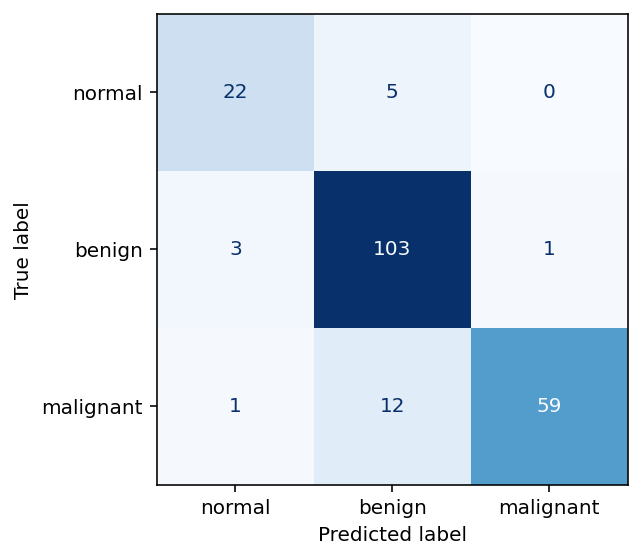

In [35]:
cm = confusion_matrix(y_true=df_test['label'], y_pred=df_test['pred'])
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot(cmap='Blues', colorbar=False)
plt.tight_layout()

## Feature Extractor

In [36]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for ii, (train_indices, valid_indices) in enumerate(skfold.split(df_train, df_train['label']), start=1):

    train = df_train.iloc[train_indices]
    valid = df_train.iloc[valid_indices]

    # Split data into traininig and validation sets
    train_data = BUSIDataset(train, transform=transforms_dict['train'])
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

    valid_data = BUSIDataset(valid, transform=transforms_dict['valid'])
    valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    print('\n-------')
    print(f'FOLD {ii}')
    print('-------\n')

    # Select avaiable device: GPU or CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Instantiate the model
    model = BUSIClassifier(pretrained=True, requires_grad=False)
    model.to(device)

    # Define the loss, optimizar and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, verbose=True)

    epochs = 100

    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [], 
        'valid_loss': [], 'valid_acc': [], 'valid_f1': [],
    }

    valid_loss_min = np.Inf

    for epoch in trange(epochs):

        train_loss, train_acc, train_f1 = model_train(train_loader, model, criterion, optimizer)
        valid_loss, valid_acc, valid_f1 = model_eval(valid_loader, model, criterion)

        print(f'Epoch: {epoch + 1:02d}/{epochs:02d} ',
              f'Training loss: {train_loss:10.5f} | ',
              f'Training Accuracy: {train_acc:5.2%} | ',
              f'Training f1 score: {train_f1:.5f} | '
              f'Validation loss: {valid_loss:10.5f} | ',
              f'Validation Accuracy: {valid_acc:5.2%} | ',
              f'Validation f1 score: {valid_f1:5.5f}')

        if valid_loss <= valid_loss_min:
            print(f'Validation loss decresead: {valid_loss_min:.5f} --> {valid_loss:.5f}. Saving model...')            
            valid_loss_min = valid_loss
            best_model  = torch.save(model.state_dict(), f'model_{ii:02d}.pt')
            best_model_train_loss = train_loss
            best_model_train_acc = train_acc
            best_model_train_f1 = train_f1
            best_model_valid_loss = valid_loss
            best_model_valid_acc = valid_acc
            best_model_valid_f1 = valid_f1

        history['train_loss'].append(best_model_train_loss)
        history['train_acc'].append(best_model_train_acc)
        history['train_f1'].append(best_model_train_f1)
        history['valid_loss'].append(best_model_valid_loss)
        history['valid_acc'].append(best_model_valid_acc)
        history['valid_f1'].append(best_model_valid_f1)

print('\n--------------')            
print(f"Training loss: {np.mean(history['train_loss']):.5f} +/- {np.std(history['train_loss']):.5f} | "
      f"Validation loss: {np.mean(history['valid_loss']):.5f} +/- {np.std(history['valid_loss']):.5f} | "
      f"Training accuracy: {np.mean(history['train_acc']):.2%} +/- {np.std(history['train_acc']):.2%} | "
      f"Validation accuracy: {np.mean(history['valid_acc']):.2%} +/- {np.std(history['valid_acc']):.2%} | "
      f"Training f1 score: {np.mean(history['train_f1']):.5f} +/- {np.std(history['train_f1']):.5f} | "
      f"Validation f1 score: {np.mean(history['valid_f1']):.5f} +/- {np.std(history['valid_f1']):.5f}")
print('--------------')


-------
FOLD 1
-------

[INFO] pretrained is True
[INFO] requires_grad is False


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01/100  Training loss:    0.98958 |  Training Accuracy: 52.50% |  Training f1 score: 0.38453 | Validation loss:    0.90279 |  Validation Accuracy: 57.58% |  Validation f1 score: 0.37952
Validation loss decresead: inf --> 0.90279. Saving model...
Epoch: 02/100  Training loss:    0.79859 |  Training Accuracy: 63.28% |  Training f1 score: 0.51000 | Validation loss:    0.78829 |  Validation Accuracy: 70.91% |  Validation f1 score: 0.61208
Validation loss decresead: 0.90279 --> 0.78829. Saving model...
Epoch: 03/100  Training loss:    0.75249 |  Training Accuracy: 64.06% |  Training f1 score: 0.52113 | Validation loss:    0.73362 |  Validation Accuracy: 68.48% |  Validation f1 score: 0.48676
Validation loss decresead: 0.78829 --> 0.73362. Saving model...
Epoch: 04/100  Training loss:    0.65454 |  Training Accuracy: 73.28% |  Training f1 score: 0.64628 | Validation loss:    0.63188 |  Validation Accuracy: 74.55% |  Validation f1 score: 0.66206
Validation loss decresead: 0.73362 --> 0

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01/100  Training loss:    0.97708 |  Training Accuracy: 55.78% |  Training f1 score: 0.38320 | Validation loss:    0.86297 |  Validation Accuracy: 56.36% |  Validation f1 score: 0.34123
Validation loss decresead: inf --> 0.86297. Saving model...
Epoch: 02/100  Training loss:    0.77096 |  Training Accuracy: 66.25% |  Training f1 score: 0.47836 | Validation loss:    0.85766 |  Validation Accuracy: 53.94% |  Validation f1 score: 0.40736
Validation loss decresead: 0.86297 --> 0.85766. Saving model...
Epoch: 03/100  Training loss:    0.71235 |  Training Accuracy: 69.38% |  Training f1 score: 0.59597 | Validation loss:    0.71799 |  Validation Accuracy: 60.00% |  Validation f1 score: 0.39079
Validation loss decresead: 0.85766 --> 0.71799. Saving model...
Epoch: 04/100  Training loss:    0.65163 |  Training Accuracy: 74.38% |  Training f1 score: 0.65632 | Validation loss:    0.62400 |  Validation Accuracy: 76.36% |  Validation f1 score: 0.72765
Validation loss decresead: 0.71799 --> 0

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01/100  Training loss:    0.97571 |  Training Accuracy: 49.69% |  Training f1 score: 0.35015 | Validation loss:    0.87998 |  Validation Accuracy: 61.21% |  Validation f1 score: 0.43118
Validation loss decresead: inf --> 0.87998. Saving model...
Epoch: 02/100  Training loss:    0.78960 |  Training Accuracy: 64.22% |  Training f1 score: 0.49836 | Validation loss:    0.78077 |  Validation Accuracy: 70.91% |  Validation f1 score: 0.58994
Validation loss decresead: 0.87998 --> 0.78077. Saving model...
Epoch: 03/100  Training loss:    0.68570 |  Training Accuracy: 73.59% |  Training f1 score: 0.65186 | Validation loss:    0.68549 |  Validation Accuracy: 72.73% |  Validation f1 score: 0.64325
Validation loss decresead: 0.78077 --> 0.68549. Saving model...
Epoch: 04/100  Training loss:    0.65476 |  Training Accuracy: 72.66% |  Training f1 score: 0.62148 | Validation loss:    0.62209 |  Validation Accuracy: 76.97% |  Validation f1 score: 0.71998
Validation loss decresead: 0.68549 --> 0

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01/100  Training loss:    0.95776 |  Training Accuracy: 52.19% |  Training f1 score: 0.36682 | Validation loss:    0.91987 |  Validation Accuracy: 47.88% |  Validation f1 score: 0.33344
Validation loss decresead: inf --> 0.91987. Saving model...
Epoch: 02/100  Training loss:    0.77288 |  Training Accuracy: 63.44% |  Training f1 score: 0.48490 | Validation loss:    0.80822 |  Validation Accuracy: 59.39% |  Validation f1 score: 0.39041
Validation loss decresead: 0.91987 --> 0.80822. Saving model...
Epoch: 03/100  Training loss:    0.67599 |  Training Accuracy: 71.72% |  Training f1 score: 0.59986 | Validation loss:    0.72941 |  Validation Accuracy: 66.67% |  Validation f1 score: 0.50861
Validation loss decresead: 0.80822 --> 0.72941. Saving model...
Epoch: 04/100  Training loss:    0.62523 |  Training Accuracy: 74.84% |  Training f1 score: 0.69160 | Validation loss:    0.76014 |  Validation Accuracy: 67.27% |  Validation f1 score: 0.50980
Epoch: 05/100  Training loss:    0.62305

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01/100  Training loss:    0.96353 |  Training Accuracy: 52.19% |  Training f1 score: 0.36273 | Validation loss:    0.92662 |  Validation Accuracy: 58.54% |  Validation f1 score: 0.41530
Validation loss decresead: inf --> 0.92662. Saving model...
Epoch: 02/100  Training loss:    0.76942 |  Training Accuracy: 63.91% |  Training f1 score: 0.47987 | Validation loss:    0.79342 |  Validation Accuracy: 62.80% |  Validation f1 score: 0.46069
Validation loss decresead: 0.92662 --> 0.79342. Saving model...
Epoch: 03/100  Training loss:    0.68542 |  Training Accuracy: 70.00% |  Training f1 score: 0.60479 | Validation loss:    0.74336 |  Validation Accuracy: 70.12% |  Validation f1 score: 0.51441
Validation loss decresead: 0.79342 --> 0.74336. Saving model...
Epoch: 04/100  Training loss:    0.66770 |  Training Accuracy: 70.47% |  Training f1 score: 0.63521 | Validation loss:    0.68860 |  Validation Accuracy: 68.29% |  Validation f1 score: 0.51145
Validation loss decresead: 0.74336 --> 0

## Evaluating model

In [37]:
y_pred_list = []

for jj in trange(1, 6):

    # Load saved model
    model.load_state_dict(torch.load(f'model_{jj:02d}.pt'))

    y_pred = []

    with torch.no_grad():
        
        model.eval()
        for images, _ in tqdm(test_loader):
            images = images.to(device)

            logits = model(images)

            _, preds = torch.max(logits, dim=1)
            y_pred.extend(preds.detach().cpu().numpy())
            
    y_pred_list.append(y_pred)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [38]:
df_test['pred'] = np.column_stack(y_pred_list).mean(axis=1).round()
df_test['pred'] = df_test['pred'].astype('int')  # cast predicted values
df_test

,image_path,label,pred
650,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (21).png,2,2
470,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (112).png,0,1
679,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (43).png,2,1
760,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (69).png,2,2
212,./originals/benign/us33.bmp,1,1
...,...,...,...
525,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (132).png,0,0
603,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (143).png,2,1
630,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (149).png,2,2
85,./originals/malignant/us211.bmp,2,2


In [39]:
target_names = ['normal', 'benign', 'malignant']
print(classification_report(y_true=df_test['label'], y_pred=df_test['pred'], target_names=target_names))

              precision    recall  f1-score   support

      normal       0.75      0.44      0.56        27
      benign       0.75      0.89      0.81       107
   malignant       0.83      0.72      0.77        72

    accuracy                           0.77       206
   macro avg       0.77      0.68      0.71       206
weighted avg       0.78      0.77      0.76       206



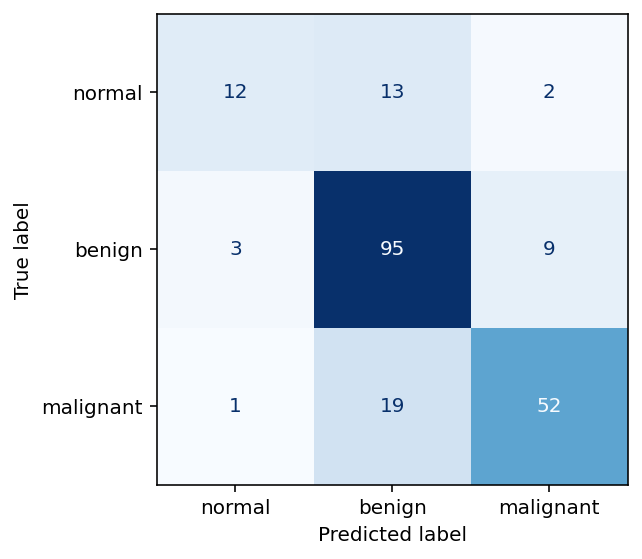

In [40]:
cm = confusion_matrix(y_true=df_test['label'], y_pred=df_test['pred'])
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot(cmap='Blues', colorbar=False)
plt.tight_layout()